# NLP Final Project: Authorship Attribution

## Yuval Timen

We will be exploring the task of Authorship Attribution - trying to assign to each piece of text the author who wrote it. We will be looking at the works of Robert Browning, Winston Churchill (the American author, not the British Prime Minister), Henry Wadsworth Longfellow, Mark Twain, William Shakespeare, and Percy Bysshe Shelley. All data was collected from Project Gutenburg.

We originally used authors such as Aristotle and Nietzsche, however, after realizing that the data collected for these authors was a translation composed of various translators, we decided to only use works originally written in English.

In [43]:
# Imports
import re
import numpy as np
import pandas as pd
from random import shuffle
from math import floor
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

%matplotlib inline

## Constants

We define some constants here that we will use later in the program.

In [2]:
# Define the list of stopwords to use by default
STOP_WORDS = set(stopwords.words('english'))

# We examine this number of sentences at a time when making predictions
SENTENCES_PER_INPUT = 6

# The percent of examples used to train
# Test set size is (1-train_percent)*num_examples
train_percent = 0.8

# The classes corresponding to each author
label_mapping = {
    'browning': 1, 
    'churchill': 2,
    'longfellow': 3,
    'twain': 4,
    'shakespeare': 5,
    'shelley': 6
}

## Import the data

In [3]:
# Importing the raw data

# Each data file is a String
with open('./data_files/browning.txt', 'r') as fb:
    data_browning = fb.read()
    
with open('./data_files/churchill.txt', 'r') as fc:
    data_churchill = fc.read()
    
with open('./data_files/longfellow.txt', 'r') as fl:
    data_longfellow = fl.read()
    
with open('./data_files/twain.txt', 'r') as ft:
    data_twain = ft.read()
    
with open('./data_files/shakespeare.txt', 'r') as fse:
    data_shakespeare = fse.read()
    
with open('./data_files/shelley.txt', 'r') as fsl:
    data_shelley = fsl.read()

In [4]:
raw_documents = [
    data_browning,
    data_churchill,
    data_longfellow,
    data_twain,
    data_shakespeare,
    data_shelley
]

## Preprocessing and Cleaning

We examine our data to see what sort of cleaning needs to be done. We remove all unwanted characters, replace any symbols with their English equivalents, and do any additional processing as necessary. Some preprocessing was done by hand, such as manually deleting the table of contents or Project Gutenberg licences at the end of the file. The rest was done programmatically. 

In [5]:
# Let's first see what kind of characters are in our text:

def build_charset(documents):
    all_chars = list() 
    for doc in documents:
        all_chars.extend(list(doc))
    print(set(all_chars))
    return all_chars

all_chars = build_charset(raw_documents)

{'6', ']', '=', 'ρ', 'd', 'נ', '@', 'ή', 'œ', '-', 'æ', 'H', '~', 'ε', 'ὲ', 'χ', 'λ', 'ὸ', 'ξ', 'η', '’', '>', 'ὅ', 'Y', '0', '{', 'ᾴ', 'h', '·', '?', '\n', 'ὖ', 'q', 'l', 'û', 'ἤ', 'Ὕ', '&', 'ό', 'c', '“', 'ὐ', 'υ', 'm', 'τ', 'ῖ', '^', '1', 'ῥ', '9', '£', 'ἐ', '\t', 'ל', 'β', 'p', 'v', 'L', '$', 'o', 's', 'à', 'ק', '3', 'έ', 'ά', 'ê', 'ᵒ', '‘', '7', 'ἰ', '2', 'ù', '־', '<', '”', '׃', "'", 'ῃ', 'ὼ', 'ὁ', '—', 'ἴ', 'ω', 'ç', 'b', 'ד', ':', 'י', 'É', 'n', 'Υ', '5', 'ò', 'ה', 'ט', 'ר', 'ע', 'ὔ', '!', 'ὶ', 'T', 'u', 't', 'F', ')', 'á', 'ï', 'E', 'B', 'O', 'ו', 'Χ', 'ē', '[', 'ú', 'ῆ', 'e', '\\', '+', 'ς', 'r', 'w', 'ש', 'g', 'A', 'ó', 'a', 'σ', 'ῦ', 'ἀ', '/', 'è', 'ύ', 'Q', 'j', '`', 'έ', 'ì', 'J', 'א', 'ׁ', 'ך', '(', 'ὴ', '*', 'μ', 'À', 'â', 'ὰ', 'ύ', 'Œ', 'ῶ', '}', 'î', 'φ', 'π', 'ά', '4', '|', 'i', 'Σ', ' ', 'x', 'y', 'Θ', 'ἔ', 'P', 'ἱ', '_', 'I', 'f', '"', 'é', 'D', 'Î', 'α', 'δ', 'S', '.', 'ι', 'W', 'θ', 'ë', 'ם', '‡', 'z', 'X', 'ο', 'M', 'ί', 'ב', 'ὃ', 'Ἀ', '%', 'κ', ';', 'V', 'ô', '

In [6]:
# We see that, in addition to symbols and punctuation, we have
# some Greek and Hebrew words. We must make sure to substitute them
# for special tokens during data cleaning.
# For Greek words, we will use _GREEK_WORD_ token,
# and for Hebrew we will use _HEBREW_WORD_ token.

# This function takes in a String of data and
# returns a list of sentences. It removes
# all punctuation, symbols, numbers, and quotation 
# marks. Finally, we turn all upper-case into lower-case.
# If the resulting sentence does not contain enough words, we exclude it. 
def clean_data(data, word_threshold=3, stopwords_to_remove=STOP_WORDS, num_sentences_per_input=SENTENCES_PER_INPUT):
    
    # Define the stopword regex
    regex_stopwords = r"\b(" + "|".join(stopwords_to_remove) + r")\b"
    
    # Define common regex for cleaning
    regex_numbers = r'[0-9]'
    regex_amounts = '£[0-9]+(.*[0-9]*)*'
    regex_punctuation = r'([\“\”·£־§”$&*ᵒ%+=`‘.,;:_"\/\\\(\)\[\]!?<>\—\-\‐]|\n|--)'
    
    # Expressions matching a single quote that:
    # - precede a word
    # - follow a word
    # - are not next to a word
    regex_single_quote_start = r"([^a-zA-Z])\\'([a-zA-Z])"
    regex_single_quote_end = r"([a-zA-Z])\\'([^a-zA-Z])"
    regex_single_quote_standalone = r"([^a-zA-Z])\\'([^a-zA-Z])"
    
    # Expressions matching symbols/special characters
    # Some symbols can be replaced with ascii characters,
    # such as æ -> ae, or È -> e
    regex_replaceable_ae = r'[Ææ]'
    regex_replaceable_c = r'[Çç]'
    regex_replaceable_a = r'[ÀÁÂÄàáâä]'
    regex_replaceable_e = r'[ÉÊÈêéèēë]'
    regex_replaceable_oe = r'[Œœ]'
    regex_replaceable_u = r'[ÜÛüûùú]'
    regex_replaceable_i = r'[ÏÎìïî]'
    regex_replaceable_o = r'[ÔÖôöòó]'
    
    # Some words are entirely non-English, and must 
    # be transformed to a special token. 
    regex_greek = r'([ὔνΣῡὝύᾴαδθυοπὶἀὖἄἔἆωῥγτῃῆάζἰἤύόχέῶΘὸὴρόὃῑξφηΙμἐλΧςώὼιίάῦβήἈ᾽ἑὲὀεἴἱσκέ]+?)+'
    regex_hebrew = r'([ןזסשדטתאהלכשׁרפךחמבצנףוםקעיץג]+?)+'
    
    # Book or chapter headings often contain Roman numerals
    regex_book = r'^BOOK (((?=[MDCLXVI])M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(I[XV]|V?I{0,3}))\s)'
    regex_chapter = r'^CHAPTER (((?=[MDCLXVI])M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(I[XV]|V?I{0,3}))\s)'
    regex_roman_num = r'(?!I)((?=[MDCLXVI])M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(I[XV]|V?I{0,3}))\s'    
    
    # Regex to match any word containing a non-ascii character
    regex_non_ascii = r"[^ -~]"
    
    
    # Before we begin sentence tokenization,
    # we remove all chapter headings. We do 
    # this before, because tokenization
    # will make it tricky to eliminate 
    # all headings consistently.
    data = re.sub(regex_book, ' ', data, re.IGNORECASE)
    data = re.sub(regex_chapter, ' ', data, re.IGNORECASE)
    
    sentences = sent_tokenize(data)
    output = []
    
    current_input = ""
    count = 0
    
    for sent in sentences:
        tmp = sent
        
        # Remove all unwanted characters
        tmp = re.sub(regex_amounts, ' ', tmp)
        tmp = re.sub(regex_numbers, ' ', tmp)
        tmp = re.sub(regex_punctuation, ' ', tmp)

        # Remove all quotes, preserving single apostrophes
        tmp = re.sub(regex_single_quote_start, r'\1 \2', tmp)
        tmp = re.sub(regex_single_quote_end, r'\1 \2', tmp)
        tmp = re.sub(regex_single_quote_standalone, r'\1 \2', tmp)
        
        # Replace all symbols with corresponding English characters
        tmp = re.sub(regex_replaceable_ae, 'ae', tmp)
        tmp = re.sub(regex_replaceable_c, 'c', tmp)
        tmp = re.sub(regex_replaceable_a, 'a', tmp)
        tmp = re.sub(regex_replaceable_e, 'e', tmp)
        tmp = re.sub(regex_replaceable_oe, 'oe', tmp)
        tmp = re.sub(regex_replaceable_u, 'u', tmp)
        tmp = re.sub(regex_replaceable_i, 'i', tmp)
        tmp = re.sub(regex_replaceable_o, 'o', tmp)
        
        # Replace foreign languages with corresponding tokens
        tmp = re.sub(regex_greek, '_GREEK_WORD_', tmp)
        tmp = re.sub(regex_hebrew, '_HEBREW_WORD_', tmp)
        
        tmp = tmp.lower()
        tmp = tmp.strip()
        
        # If the sentence still contains a Roman Numeral, we don't want it
        if (re.search(regex_roman_num, tmp, re.IGNORECASE)):
            continue
            
        # Remove any stopwords if necessary
        if stopwords_to_remove:
            tmp = re.sub(regex_stopwords, '', tmp)
            
        # We've reached the end of cleaning, remove any words that contain non-ascii characters
        # This acts as the last filter, in case previous preprocessing missed anything
        tmp = re.sub(regex_non_ascii, '', tmp)
        
        # The sentence must have the minimum word threshold to be included
        if tmp and len(tmp.split()) >= word_threshold:
            
            # Since it's above the word threshold, we will be using the sentence
            count += 1
            
            # If we've reached the limit, add to output and clear accumulator
            if count % num_sentences_per_input == 0:
                output.append(" ".join([current_input, tmp]))
                current_input = ""
            else:
                current_input = " ".join([current_input, tmp])
                
    # If there are any remaining sentences in the accumulator when we are
    # done, we just print them out. We do not want to use an input that 
    # has less than SENTENCES_PER_INPUT sentence. While these extra sentences
    # would be okay to be converted into inputs, for the purpose of this
    # experiment, we want to have every aspect be as standard as possible. 
    if current_input:
        print("Unused sentences: " + current_input)
                
    
    return output

In [7]:
# Convert all of our data into cleaned lines
browning_cleaned = clean_data(data_browning)
churchill_cleaned = clean_data(data_churchill)
longfellow_cleaned = clean_data(data_longfellow)
twain_cleaned = clean_data(data_twain)
shakespeare_cleaned = clean_data(data_shakespeare)
shelley_cleaned = clean_data(data_shelley)

Unused sentences:  ' become  waring woe   went galloping   war   sick  ' sure     say  blame    ran away   seen better days  dear
Unused sentences:    attempting  turn calamity  good
Unused sentences:  tristia  book iii   elegy x tristia  book iii   elegy xii    sea  frozen     'er  ister   comes  sarmatian boor driving  stridulous cart
Unused sentences:  let  go       way  settle  let us draw  line  money   lost   game
Unused sentences:  dost thou drink tears   thou provokst  weeping  may  heavy groan advantage thee  face remains alive  worth  viewing  canst thou boast  things long since   anything ensuing
Unused sentences:    spirits   air   oh whose waves  years   unrisen splendour   brightest sun    vessels  heavenly medicine


## Data Exploration & Statistics

We generate some basic statistics about the data, such as sentence and word count, sentence and word length, and vocabulary size. We then run a pairwise set difference across all the vocabularies of our authors. Finally, we create a frequency graph to visualize these vocabulary differences.

In [8]:
# Prints some basic statistics about our dataset:
# 1. Total Number of Sentences
# 2. Average Sentence Length in Words
# 3. Total Number of Words
# 4. Average Word Length in Characters
# 5. Vocabulary Size
# The function returns the vocabulary of the dataset
def print_dataset_statistics(sentences):
    num_sentences = len(sentences) * SENTENCES_PER_INPUT
    avg_sent_length = np.mean([len(sent.split()) for sent in sentences]) / SENTENCES_PER_INPUT
    all_words = []
    for sent in sentences:
        all_words.extend(sent.split())
    avg_word_length = np.mean([len(word) for word in all_words])
    num_words = len(all_words)
    vocab_size = len(set(all_words))
    
    print(f"Total sentences: {num_sentences}")
    print(f"Average sentence length: {round(avg_sent_length, 3)} words")
    print(f"Total number of words: {num_words}")
    print(f"Average word length {round(avg_word_length, 3)} characters")
    print(f"Vocabulary size: {vocab_size}")
    print('\n')
    
    return list(all_words)

print("---Browning statistics---")
all_words_browning = print_dataset_statistics(browning_cleaned)

print("---Churchill statistics---")
all_words_churchill = print_dataset_statistics(churchill_cleaned)

print("---Longfellow statistics---")
all_words_longfellow = print_dataset_statistics(longfellow_cleaned)

print("---Twain statistics---")
all_words_twain = print_dataset_statistics(twain_cleaned)

print("---Shakespeare statistics---")
all_words_shakespeare = print_dataset_statistics(shakespeare_cleaned)
 
print("---Shelley statistics---")
all_words_shelley = print_dataset_statistics(shelley_cleaned)

---Browning statistics---
Total sentences: 5172
Average sentence length: 4.829 words
Total number of words: 24975
Average word length 5.152 characters
Vocabulary size: 6849


---Churchill statistics---
Total sentences: 10554
Average sentence length: 4.634 words
Total number of words: 48907
Average word length 5.356 characters
Vocabulary size: 8911


---Longfellow statistics---
Total sentences: 2034
Average sentence length: 4.556 words
Total number of words: 9266
Average word length 5.31 characters
Vocabulary size: 3322


---Twain statistics---
Total sentences: 11934
Average sentence length: 4.796 words
Total number of words: 57230
Average word length 5.376 characters
Vocabulary size: 11135


---Shakespeare statistics---
Total sentences: 11736
Average sentence length: 4.444 words
Total number of words: 52152
Average word length 5.139 characters
Vocabulary size: 8163


---Shelley statistics---
Total sentences: 2016
Average sentence length: 5.012 words
Total number of words: 10105
Average

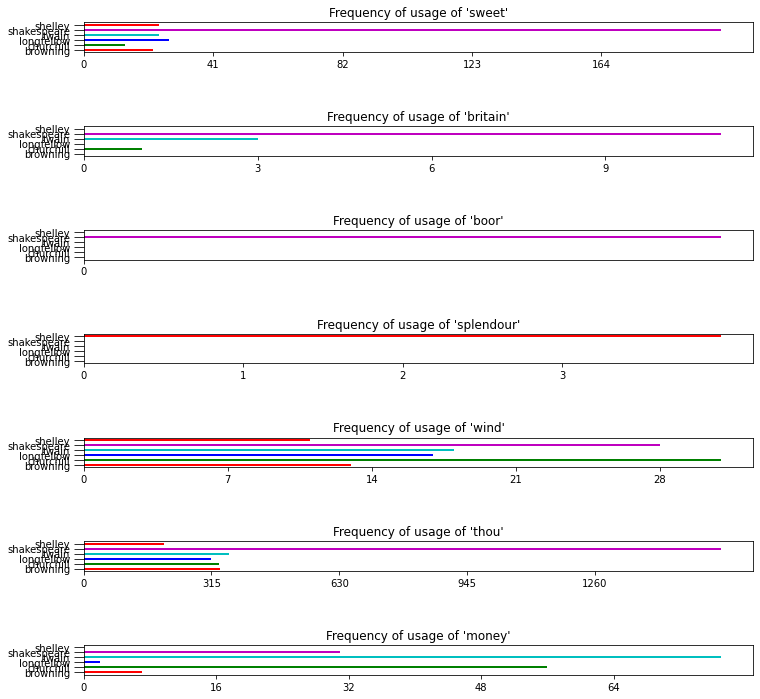

In [66]:
# Visualize distribution of words
# We pick some words and examine the frequency with which
# they occur in the different documents. 

browning_doc = " ".join(browning_cleaned)
churchill_doc = " ".join(churchill_cleaned)
longfellow_doc = " ".join(longfellow_cleaned)
twain_doc = " ".join(twain_cleaned)
shakespeare_doc = " ".join(shakespeare_cleaned)
shelley_doc = " ".join(shelley_cleaned)

# For a few common words, create a histogram over the authors showing their usage of the particulary word
words_to_vis = ['sweet', 'britain', 'boor', 'splendour', 'wind', 'thou', 'money']
author_docs = {
    'browning': browning_doc, 
    'churchill': churchill_doc, 
    'longfellow': longfellow_doc, 
    'twain': twain_doc, 
    'shakespeare': shakespeare_doc, 
    'shelley': shelley_doc
}

def visualize_word_list(words, documents):
    authors = list(documents.keys())
    y_pos = np.arange(len(authors))
    y_pos = [2 * p for p in y_pos]
    counts = dict()
    
    
    fig, axs = plt.subplots(nrows=len(words), figsize=(12, 12))
    
    for i, word in enumerate(words):
        max_counts = 0
        current = [doc.count(word) for doc in documents.values()]
        counts[word] = current
        
        for each in current:
            max_counts = max(each, max_counts)
            
        axs[i].barh(y_pos, counts[word], align='center', color=['r', 'g', 'b', 'c', 'm'])
        axs[i].set_xticks(np.arange(0, max_counts, 1 + floor(0.2 * max_counts)))
        axs[i].set_yticks(y_pos)
        axs[i].set_yticklabels(authors)
        axs[i].tick_params(axis='y', which='major', labelsize=10, length=10)
        axs[i].set_title(f"Frequency of usage of '{word}'")       
    
    plt.subplots_adjust(wspace=2, hspace=2.5)
    plt.show()
    return fig, axs

    
    

fig, axs = visualize_word_list(words_to_vis, author_docs)

In [10]:
# Pairwise set differences in vocabulary.

# Overlap Measure metric for measuring set similarity
# Given two sets, A and B, we calculate the Overlap as follows:
# J(A,B) = |intersection(A,B)| / min(|A|,|B|)
def overlap_measure(setA, setB):
    intersect = len(set(setA).intersection(set(setB)))
    denom = min(len(set(setA)), len(set(setB)))
    ans = 100 * intersect / denom
    return ans


# Given a list of sets and a metric function, this function will
# conduct a pairwise set evalution. For example, given s1, s2, s3,
# and the function f(), this function will yield:
# f(s1, s2), f(s1, s3), f(s2, s3)
def pairwise_metrics(func, list_of_sets):
    
    output = []
    total = len(list_of_sets)
    
    for i in range(total):
        cur = list_of_sets[i]
        rest = list_of_sets[i+1:]
        
        for other in rest:
            output.append(func(cur, other))
            
    return output


# Given the result of pairwise_metrics, this function
# formats and prints the statistics for us to see neatly.
def print_vocab_metrics(vocabs):
    
    metric_list = pairwise_metrics(overlap_measure, vocabs)
    
    print(f"Minimum overlap: {str(min(metric_list))[:4]}%")
    print(f"Maximum overlap: {str(max(metric_list))[:4]}%")
    print(f"Average overlap: {str(np.mean(metric_list))[:4]}%")
    

# Define the list of all vocabularies
all_vocabs = [all_words_browning, 
              all_words_churchill, 
              all_words_longfellow, 
              all_words_twain,
              all_words_shakespeare, 
              all_words_shelley]

entire_vocab = list()
for v in all_vocabs:
    entire_vocab.extend(v)

entire_vocab = list(set(entire_vocab))

print_vocab_metrics(all_vocabs)

Minimum overlap: 35.4%
Maximum overlap: 58.5%
Average overlap: 47.5%


## Featurization

We featurize our data in 2 ways. The baseline method will be to create one-hot encodings for each word in the sample paragraph. The features for a single input paragraph will be the vector sum of all one-hot vectors for each word in the given paragraph. Essentially, this will be a vector of length |V|, where V is the set of vocabulary words; the words that appear in the paragraph will have a 1 in the position of their index in the vector, indicating that they are present. All other indices will be 0. This is the one-hot vector equivalent of Bag-of-Words.

The second method is a TF-IDF vector representation for each author. We convert the input paragraphs to a co-occurrence matrix, where each row represents a paragraph and each column represents a word; the element at the i,j position is the number of times word j appears in paragraph i. We then scale these numbers by a learned IDF term - the inverse document frequency for each word. To turn these paragraphs into usable input features for our models, we add together the word vectors for all the words in a given paragraph. While this does not technically produce a TF-IDF vector, it still produces a vector encoding the relative importance of words. 

In [11]:
# Imports 
from functools import reduce

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

### First method - create the one-hot encodings

In [12]:
# Converts a list of sentences to a list of lists of words
def sentences_to_word_lists(sentences):
    output = []
    for sent in sentences:
        output.append(sent.split())
    return output
    

browning_listed = sentences_to_word_lists(browning_cleaned)
churchill_listed = sentences_to_word_lists(churchill_cleaned)
longfellow_listed = sentences_to_word_lists(longfellow_cleaned)
twain_listed = sentences_to_word_lists(twain_cleaned)
shakespeare_listed = sentences_to_word_lists(shakespeare_cleaned)
shelley_listed = sentences_to_word_lists(shelley_cleaned)

In [13]:
# Takes a list of list of words and an encoder and
# returns a list of list of integers
def encode_sentences(sentences, encoder, reshape=False):
    output = []
    for sent in sentences:
        if reshape:
            sent = sent.reshape(len(sent), 1)
        output.append(encoder.transform(sent))
    
    return output

# Create the indexer and fit it to the entire vocabulary
label_encoder = LabelEncoder()
label_encoder.fit(entire_vocab)

# We need to reshape the result so its a column vector
vocab_indexed = label_encoder.transform(entire_vocab)
vocab_indexed = vocab_indexed.reshape(len(vocab_indexed), 1)

# Index our data
browning_indexed = encode_sentences(browning_listed, label_encoder)
churchill_indexed = encode_sentences(churchill_listed, label_encoder)
longfellow_indexed = encode_sentences(longfellow_listed, label_encoder)
twain_indexed = encode_sentences(twain_listed, label_encoder)
shakespeare_indexed = encode_sentences(shakespeare_listed, label_encoder)
shelley_indexed = encode_sentences(shelley_listed, label_encoder)

# Create the OneHotEncoder and fit it to the indexed vocab
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
onehot_encoder.fit(vocab_indexed)

# One Hot Encode all of our data
browning_onehot = encode_sentences(browning_indexed, onehot_encoder, reshape=True)
churchill_onehot = encode_sentences(churchill_indexed, onehot_encoder, reshape=True)
longfellow_onehot = encode_sentences(longfellow_indexed, onehot_encoder, reshape=True)
twain_onehot = encode_sentences(twain_indexed, onehot_encoder, reshape=True)
shakespeare_onehot = encode_sentences(shakespeare_indexed, onehot_encoder, reshape=True)
shelley_onehot = encode_sentences(shelley_indexed, onehot_encoder, reshape=True)

In [14]:
# Takes in a a list of 2D numpy array, each of shape 
# (n, V) where n is the number of words in a sentence 
# and V is the vocab size. This function returns a 
# list of 1D np.arrays representing the condensed 
# encodings. 
def consolidate_encodings(all_encodings):
    output = []
    shape = all_encodings[0].shape
    for enc in all_encodings:
        
        output.append(np.array(reduce(lambda a1, a2: a1 + a2, list(enc), np.zeros((1, shape[1])))))
        
    return output

In [15]:
# Convert the one-hot encoded list of lists into a single encoded list
browning_encoded = consolidate_encodings(browning_onehot)
churchill_encoded = consolidate_encodings(churchill_onehot)
longfellow_encoded = consolidate_encodings(longfellow_onehot)
twain_encoded = consolidate_encodings(twain_onehot)
shakespeare_encoded = consolidate_encodings(shakespeare_onehot)
shelley_encoded = consolidate_encodings(shelley_onehot)

(1, 23934)


In [16]:
# We split the data into X (matrix: (n_samples, n_features))
# and y: (n_samples, 1).
encoded_data = np.array(browning_encoded 
                + churchill_encoded 
                + longfellow_encoded 
                + twain_encoded
                + shakespeare_encoded
                + shelley_encoded)

encoded_data = encoded_data.reshape(encoded_data.shape[0], encoded_data.shape[2])

labels_ohe = np.array([label_mapping['browning'] for _ in browning_encoded]
         + [label_mapping['churchill'] for _ in churchill_encoded]
         + [label_mapping['longfellow'] for _ in longfellow_encoded]
         + [label_mapping['twain'] for _ in twain_encoded]
         + [label_mapping['shakespeare'] for _ in shakespeare_encoded]
         + [label_mapping['shelley'] for _ in shelley_encoded])

df_ohe = pd.DataFrame(encoded_data)
df_ohe['label'] = labels_ohe
df_ohe.head()

,0,1,2,3,4,5,6,7,8,9,...,23925,23926,23927,23928,23929,23930,23931,23932,23933,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [17]:
# Prepare the OneHot Encoded inputs for our models

# Shuffle everything up
df_ohe = df_ohe.sample(frac=1).reset_index(drop=True)

# Inputs for One Hot Encodings
data_X_one_hot = df_ohe.drop('label', axis=1).to_numpy()
data_y_one_hot = df_ohe['label'].to_numpy()

train_idx_cutoff_ohe = floor(len(data_y_one_hot) * train_percent)

train_X_ohe = data_X_one_hot[:train_idx_cutoff_ohe]
test_X_ohe = data_X_one_hot[train_idx_cutoff_ohe + 1:]

train_y_ohe = data_y_one_hot[:train_idx_cutoff_ohe]
test_y_ohe = data_y_one_hot[train_idx_cutoff_ohe + 1:]

### Second method - TfIdf Vectors

In [68]:
# Since we're encoding information that belongs only to the train set, 
# we want to separate our examples out early

corpus_list_of_lists = [
    browning_cleaned,
    churchill_cleaned,
    longfellow_cleaned,
    twain_cleaned,
    shakespeare_cleaned,
    shelley_cleaned
]

# Flatten out our list of lists into a single list containing sentences from all authors
corpus = []
for sublist in corpus_list_of_lists:
    for item in sublist:
        corpus.append(item)
        
# Create corresponding labels for each sentence      
labels_tfidf = np.array([label_mapping['browning'] for _ in browning_cleaned]
         + [label_mapping['churchill'] for _ in churchill_cleaned]
         + [label_mapping['longfellow'] for _ in longfellow_cleaned]
         + [label_mapping['twain'] for _ in twain_cleaned]
         + [label_mapping['shakespeare'] for _ in shakespeare_cleaned]
         + [label_mapping['shelley'] for _ in shelley_cleaned])


# Zip them up and shuffle so that each input is a tuple that looks like: (data, label)
data_tfidf = list(zip(corpus, labels_tfidf))
shuffle(data_tfidf)

# Define the index where we split the train and test data
train_idx_cutoff_tfidf = floor(len(data_tfidf) * train_percent)

# Split the data into train and test
train_tfidf = data_tfidf[:train_idx_cutoff_tfidf]
test_tfidf = data_tfidf[train_idx_cutoff_tfidf + 1:]


# Split the data up into X and y for both train and test
train_X_tfidf = [tupl[0] for tupl in train_tfidf]
train_y_tfidf = [tupl[1] for tupl in train_tfidf]

test_X_tfidf = [tupl[0] for tupl in test_tfidf]
test_y_tfidf = [tupl[1] for tupl in test_tfidf]

In [69]:
# Convert the documents to a count matrix
count_vec = CountVectorizer()
tfidf_vec = TfidfTransformer()

train_X_count = count_vec.fit_transform(train_X_tfidf).toarray()
train_X_tfidf = tfidf_vec.fit_transform(train_X_count).toarray()

test_X_count = count_vec.transform(test_X_tfidf).toarray()
test_X_tfidf = tfidf_vec.transform(test_X_count).toarray()

## Running the Models

We implement Logistic Regression and a Feed Forward Neural Network.

In [20]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [21]:
# Logistic Regression:
# Here, we implement sklearn's Logistic Regression model.

# Create models
clf_logit_ohe = LogisticRegression(n_jobs=4, verbose=True)
clf_logit_tfidf = LogisticRegression(n_jobs=4, verbose=True)

# Train with One Hot Encodings
clf_logit_ohe.fit(train_X_ohe, train_y_ohe)
predicted_logit_ohe = clf_logit_ohe.predict(test_X_ohe)

# Train with TFIDF
clf_logit_tfidf.fit(train_X_tfidf, train_y_tfidf)
predicted_logit_tfidf = clf_logit_tfidf.predict(test_X_tfidf)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  3.4min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.6min finished


In [22]:
# Feed-Forward Neural Network:
# Here, we implement sklearn's Multi-layered Perceptron model.
# This is 
clf_nn_ohe = MLPClassifier(solver='sgd', max_iter=1000, learning_rate_init=0.005, verbose=True)
clf_nn_tfidf = MLPClassifier(solver='sgd', max_iter=1000, learning_rate_init=0.005, verbose=True)

clf_nn_ohe.fit(train_X_ohe, train_y_ohe)
predicted_nn_ohe = clf_nn_ohe.predict(test_X_ohe)

clf_nn_tfidf.fit(train_X_tfidf, train_y_tfidf)
predicted_nn_tfidf = clf_nn_tfidf.predict(test_X_tfidf)

Iteration 1, loss = 1.75483087
Iteration 2, loss = 1.49851456
Iteration 3, loss = 1.33593962
Iteration 4, loss = 1.23051848
Iteration 5, loss = 1.14607247
Iteration 6, loss = 1.07326826
Iteration 7, loss = 1.00888248
Iteration 8, loss = 0.95079788
Iteration 9, loss = 0.89816207
Iteration 10, loss = 0.85088642
Iteration 11, loss = 0.80728441
Iteration 12, loss = 0.76753538
Iteration 13, loss = 0.73088545
Iteration 14, loss = 0.69673296
Iteration 15, loss = 0.66482267
Iteration 16, loss = 0.63478949
Iteration 17, loss = 0.60712945
Iteration 18, loss = 0.58111524
Iteration 19, loss = 0.55605708
Iteration 20, loss = 0.53265215
Iteration 21, loss = 0.51053013
Iteration 22, loss = 0.48932742
Iteration 23, loss = 0.46941874
Iteration 24, loss = 0.45080385
Iteration 25, loss = 0.43281354
Iteration 26, loss = 0.41544063
Iteration 27, loss = 0.39933163
Iteration 28, loss = 0.38409286
Iteration 29, loss = 0.36914397
Iteration 30, loss = 0.35489755
Iteration 31, loss = 0.34142079
Iteration 32, los

Iteration 30, loss = 1.45501392
Iteration 31, loss = 1.44639968
Iteration 32, loss = 1.43757859
Iteration 33, loss = 1.42846758
Iteration 34, loss = 1.41900944
Iteration 35, loss = 1.40918382
Iteration 36, loss = 1.39900362
Iteration 37, loss = 1.38856448
Iteration 38, loss = 1.37799812
Iteration 39, loss = 1.36699457
Iteration 40, loss = 1.35619856
Iteration 41, loss = 1.34466629
Iteration 42, loss = 1.33333073
Iteration 43, loss = 1.32176009
Iteration 44, loss = 1.31007058
Iteration 45, loss = 1.29869138
Iteration 46, loss = 1.28700582
Iteration 47, loss = 1.27528188
Iteration 48, loss = 1.26366482
Iteration 49, loss = 1.25224097
Iteration 50, loss = 1.24081382
Iteration 51, loss = 1.22941104
Iteration 52, loss = 1.21826301
Iteration 53, loss = 1.20718270
Iteration 54, loss = 1.19622464
Iteration 55, loss = 1.18551277
Iteration 56, loss = 1.17515616
Iteration 57, loss = 1.16442535
Iteration 58, loss = 1.15406316
Iteration 59, loss = 1.14363573
Iteration 60, loss = 1.13344950
Iteratio

Iteration 281, loss = 0.20364699
Iteration 282, loss = 0.20228838
Iteration 283, loss = 0.20081753
Iteration 284, loss = 0.19952130
Iteration 285, loss = 0.19816534
Iteration 286, loss = 0.19670574
Iteration 287, loss = 0.19537636
Iteration 288, loss = 0.19410211
Iteration 289, loss = 0.19280680
Iteration 290, loss = 0.19136812
Iteration 291, loss = 0.19008138
Iteration 292, loss = 0.18871616
Iteration 293, loss = 0.18757294
Iteration 294, loss = 0.18619720
Iteration 295, loss = 0.18498656
Iteration 296, loss = 0.18371475
Iteration 297, loss = 0.18246137
Iteration 298, loss = 0.18119572
Iteration 299, loss = 0.18003317
Iteration 300, loss = 0.17887934
Iteration 301, loss = 0.17753828
Iteration 302, loss = 0.17639286
Iteration 303, loss = 0.17519174
Iteration 304, loss = 0.17398515
Iteration 305, loss = 0.17282630
Iteration 306, loss = 0.17168798
Iteration 307, loss = 0.17053278
Iteration 308, loss = 0.16950026
Iteration 309, loss = 0.16831207
Iteration 310, loss = 0.16715548
Iteration 

Iteration 530, loss = 0.04974794
Iteration 531, loss = 0.04947993
Iteration 532, loss = 0.04926796
Iteration 533, loss = 0.04906135
Iteration 534, loss = 0.04884608
Iteration 535, loss = 0.04864235
Iteration 536, loss = 0.04843198
Iteration 537, loss = 0.04823161
Iteration 538, loss = 0.04802423
Iteration 539, loss = 0.04779814
Iteration 540, loss = 0.04760466
Iteration 541, loss = 0.04741465
Iteration 542, loss = 0.04720362
Iteration 543, loss = 0.04701761
Iteration 544, loss = 0.04682428
Iteration 545, loss = 0.04660455
Iteration 546, loss = 0.04640934
Iteration 547, loss = 0.04622600
Iteration 548, loss = 0.04603035
Iteration 549, loss = 0.04582845
Iteration 550, loss = 0.04562977
Iteration 551, loss = 0.04546201
Iteration 552, loss = 0.04528188
Iteration 553, loss = 0.04506902
Iteration 554, loss = 0.04489653
Iteration 555, loss = 0.04471332
Iteration 556, loss = 0.04452267
Iteration 557, loss = 0.04433884
Iteration 558, loss = 0.04415644
Iteration 559, loss = 0.04398087
Iteration 

## Evaluation

Finally, we evaluate our models and interpret our results:

In [23]:
print("--- LOGISTIC REGRESSION (OneHot) ---")
print(f"Precision: {precision_score(test_y_ohe, predicted_logit_ohe, average='weighted')}")
print(f"Recall: {recall_score(test_y_ohe, predicted_logit_ohe, average='weighted')}")
print(f"F1 Measure: {f1_score(test_y_ohe, predicted_logit_ohe, average='weighted')}")
print()
print("--- LOGISTIC REGRESSION (TFIDF) ---")
print(f"Precision: {precision_score(test_y_tfidf, predicted_logit_ohe, average='weighted')}")
print(f"Recall: {recall_score(test_y_tfidf, predicted_logit_ohe, average='weighted')}")
print(f"F1 Measure: {f1_score(test_y_tfidf, predicted_logit_ohe, average='weighted')}")
print()
print("--- NEURAL NETWORK (OneHot) ---")
print(f"Precision: {precision_score(test_y_ohe, predicted_nn_ohe, average='weighted')}")
print(f"Recall: {recall_score(test_y_ohe, predicted_nn_ohe, average='weighted')}")
print(f"F1 Measure: {f1_score(test_y_ohe, predicted_nn_ohe, average='weighted')}")
print()
print("--- NEURAL NETWORK (TFIDF) ---")
print(f"Precision: {precision_score(test_y_tfidf, predicted_nn_tfidf, average='weighted')}")
print(f"Recall: {recall_score(test_y_tfidf, predicted_nn_tfidf, average='weighted')}")
print(f"F1 Measure: {f1_score(test_y_tfidf, predicted_nn_tfidf, average='weighted')}")

--- LOGISTIC REGRESSION (OneHot) ---
Precision: 0.8640852326828109
Recall: 0.863950276243094
F1 Measure: 0.8600265218157137

--- LOGISTIC REGRESSION (TFIDF) ---
Precision: 0.22917095884537397
Recall: 0.24171270718232044
F1 Measure: 0.23293525333254278

--- NEURAL NETWORK (OneHot) ---
Precision: 0.8611618270128938
Recall: 0.8625690607734806
F1 Measure: 0.8596396800512003

--- NEURAL NETWORK (TFIDF) ---
Precision: 0.8801603568307629
Recall: 0.8791436464088398
F1 Measure: 0.8758354280069882


## 

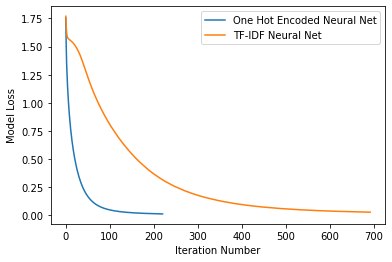

In [33]:
# Plot the loss curves for each of the Neural Nets
loss_values_ohe = clf_nn_ohe.loss_curve_
loss_values_tfidf = clf_nn_tfidf.loss_curve_

plt.plot(loss_values_ohe, label="One Hot Encoded Neural Net")
plt.plot(loss_values_tfidf, label="TF-IDF Neural Net")
plt.ylabel('Model Loss')
plt.xlabel('Iteration Number')
plt.legend(loc="upper right")
plt.show()